In [22]:
from __future__ import print_function, division
import mdtraj as md
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from mdtraj.geometry import _geometry
import os
import sys
import numpy as np
import scipy 
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patheffects as path_effects
import seaborn as sns
import math
import itertools 
import pickle
import pandas as pd
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import pyblock
from mdtraj.geometry import _geometry
from mdtraj.utils import ensure_type
from mdtraj.geometry import compute_distances, compute_angles
from scipy.stats import pearsonr

from deeptime.clustering import KMeans
from deeptime.data import double_well_2d
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales 
from deeptime.plots.chapman_kolmogorov import plot_ck_test
import pyemma.coordinates
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pyinform

import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import deeptime
from deeptime.decomposition import TICA
import pyemma
from deeptime.clustering import KMeans

In [3]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3.0

In [28]:
def fes2d(x,y,ax = None, xlabel = None,ylabel = None, cmap= 'jet',
           cbar = True, bins=250, weights=None, vmin=None,vmax=None,
           scatterx = None, scattery = None):
        z,x,y = np.histogram2d(x,y,bins=bins,weights=weights)
        extent = (x.min(), x.max(), y.min(), y.max())
        arr = np.ma.masked_array(z,z==0)
        F=-np.log(arr)
        F+=-F.min()
        if ax is None:
            fig,ax=plt.subplots(1,1,sharex=True,sharey=True)
        if not ((scatterx is None) or (scattery is None)):
            ax.scatter(scatterx, scattery, c='grey', s=60, edgecolors='black', alpha=0.5)
        a=ax.contourf(F.T,300,cmap=cmap,extent=extent,zorder=-1, vmin=vmin, vmax=vmax)
        ax.set_xlabel(xlabel,fontsize=25)
        ax.set_ylabel(ylabel,fontsize=25)
        ax.tick_params(axis="x",labelsize=20)
        ax.tick_params(axis="y",labelsize=20)
        ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))*1.0)
        if cbar:
            cb = plt.colorbar(a,ax=ax,fraction=0.046, pad=0.04,format="%.2f", )
            cb.set_label("Free Energy / (kT)",size=25,labelpad = 20)
            cb.ax.tick_params(labelsize = 20)
        return a
    
def plot_mat_error(mat,x,title,unit,
                   textsize,textcolor,cmap,ticklabs):
        """mat = square matrix
        unit = string specifying the units"""
        #fig,ax = plt.subplots(1,figsize=(20,20))
        s =ax[x].imshow(mat, cmap=cmap)
        for i in range(len(mat)):
            for j in range(len(mat)):
                c = mat[j, i]
                #e = emat[j,i]
                ax[x].text(i, j,f"{np.round(c,3)}",
                        va='center', ha='center', color = textcolor,size=textsize,weight="bold")
        ax[x].set_yticks(list(range(len(mat))), ticklabs,size=20)
        ax[x].set_xticks(list(range(len(mat))), ticklabs,size=20)
        #ax[x].set_ylabel(r"$State_{i}$", size=25)
        #ax[x].set_xlabel(r"$State_{j}$", size=25)
        #cb = plt.colorbar(s,ax=ax,label=cbarlabel,fraction=0.046,pad=0.04)
        #cb.set_label(cbarlabel, size=40)
        #cb.ax.tick_params(labelsize=30)
        ax[x].set_title(title, size = 25)
        #plt.show()
        return s
    
def kmeans(p,k):
    '''RETURNS: dtraj, frames_cl, clustercenters
    '''
    cluster = KMeans(k,max_iter=1000).fit_fetch(p)
    dtraj = cluster.transform(p)
    frames_cl = []
    for i in range(k):
        frames = np.where(dtraj==i)[0]
        frames_cl.append(frames)
    return dtraj,frames_cl,cluster.cluster_centers
def res_space(nres,space):
    arr = np.arange(nres)
    l = []
    for i in range(nres):
        l.append(arr[abs(arr-i)>space]+i*nres)
    return np.hstack(l)

def center(x):
    return x-x.mean(0)

def cov(x,y=None):
    if y is None:
        y=x
    return center(x).T@center(y)*(1/(len(x)-1))

def pca(x:np.ndarray, dim:int):
    "compute the business half of econ svd"
    l,v=np.linalg.eig(cov(x))
    idx=l.argsort()[::-1]
    v=v[...,idx]
    l=l[idx]
    l, v = l[:dim],v[...,:dim]
    projection = x@v
    return projection, l, v


In [12]:
nstates = 4
color_list = plt.cm.viridis
cs = [color_list(i) for i in range(color_list.N)]
cmap = colors.ListedColormap(cs)
boundaries = np.arange(nstates+1).tolist()
clist = [cs[int(i)] for i in np.linspace(10,len(cs)-20,nstates)]
clist = clist[::-1]

In [6]:
!pwd

/data/asn/tica/lig_47/combined


In [ ]:
dmat_lig47 = np.load("/data/asn/tica/lig_47/dist/distance_matrix_full.npy")
hbond_lig47 = np.load("/data/asn/tica/lig_47/hbond/distance_inter_hbond_matrix.npy")
hphob_lig47 = np.load("/data/asn/tica/lig_47/hphob/hphob_dist_matrix.npy")
charge_lig47 = np.load("/data/asn/tica/lig_47/charge/charge_dist_matrix.npy")
combined_lig47 = np.hstack((dmat, hbond, hphob, charge))

In [ ]:
dmat_fas = np.load("/data/asn/tica/lig_47/dist/distance_matrix_full.npy")
hbond_fas = np.load("/data/asn/tica/lig_47/hbond/distance_inter_hbond_matrix.npy")
hphob_fas = np.load("/data/asn/tica/lig_47/hphob/hphob_dist_matrix.npy")
charge_fas = np.load("/data/asn/tica/lig_47/charge/charge_dist_matrix.npy")
combined_fas = np.hstack((dmat, hbond, hphob, charge))

In [ ]:
pca_lig_47 = pca(combined_lig_47, 2)
pca_fasudil = pca(combined_fasudil, 2)

In [ ]:
##adjustable params
dim = 2
n_clusters = 4
##
dtraj_lig_47,frames_cl_lig_47,clustercenters_lig_47 = kmeans(pca_lig_47[0][:,:dim], n_clusters)

In [ ]:
##adjustable params
dim = 2
n_clusters = 4
##
dtraj_fasudil,frames_cl_fasudil,clustercenters_fasudil = kmeans(pca_fasudil[0][:,:dim], n_clusters)

/tmp/ipykernel_10874/124304887.py:7: RuntimeWarning: divide by zero encountered in log
  F=-np.log(arr)


Text(0.5, -0.04, 'PC1')

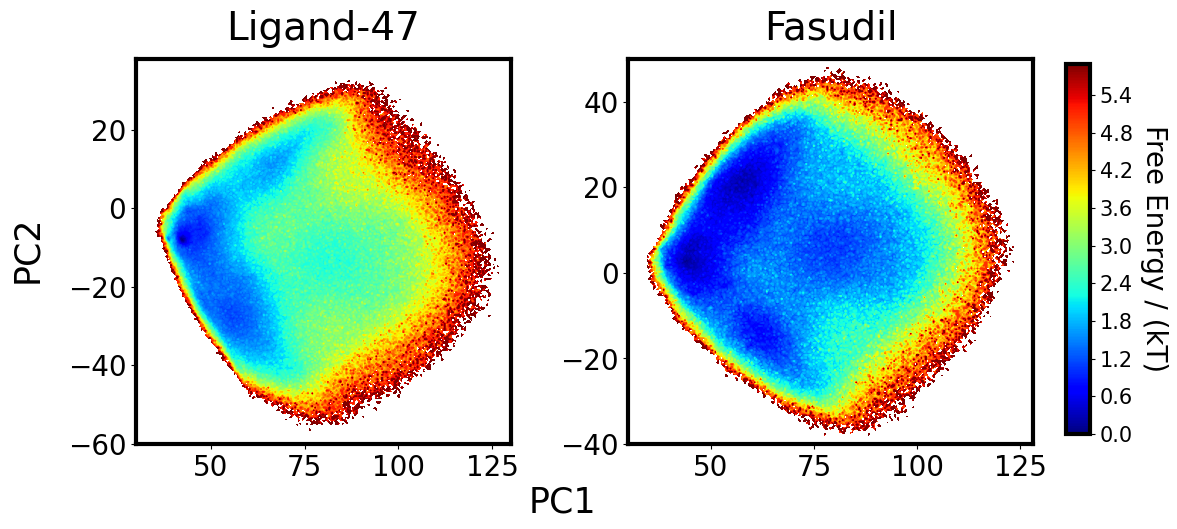

In [9]:
fig,ax = plt.subplots(1,2, sharex=False, sharey=False, figsize=(12, 5))

xlabel = 'PC1'
ylabel = 'PC2'
a = fes2d(pca_lig_47_[:,0], pca_lig_47_[:,1], ax[0], cbar = False, ) 
fes2d(pca_fasudil_[:,0], pca_fasudil_[:,1], ax[1], cbar = False) 
cbar_ax = fig.add_axes([.92, 0.13, 0.02, 0.74])#[left, bottom, width, height]
cbar = fig.colorbar(a, cax = cbar_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Free Energy / (kT)', labelpad=25, fontsize=20, rotation= 270)
ax[0].set_title('Ligand-47', size = 28,  y=1.1, pad=-14)
ax[1].set_title('Fasudil', size = 28,  y=1.1, pad=-14)
ax[0].set_xlim(30, 130)
ax[0].set_ylim(-60, 38)
ax[1].set_xlim(30, 128)
ax[1].set_ylim(-40, 50)
plt.subplots_adjust(wspace=0.2)
#plt.subplots_adjust(hspace=0.05)
fig.supylabel(ylabel,x = .04,fontsize = 25)
fig.supxlabel(xlabel,y = -0.04,fontsize = 25)
#plt.savefig('FES_PCA.pdf', bbox_inches="tight")

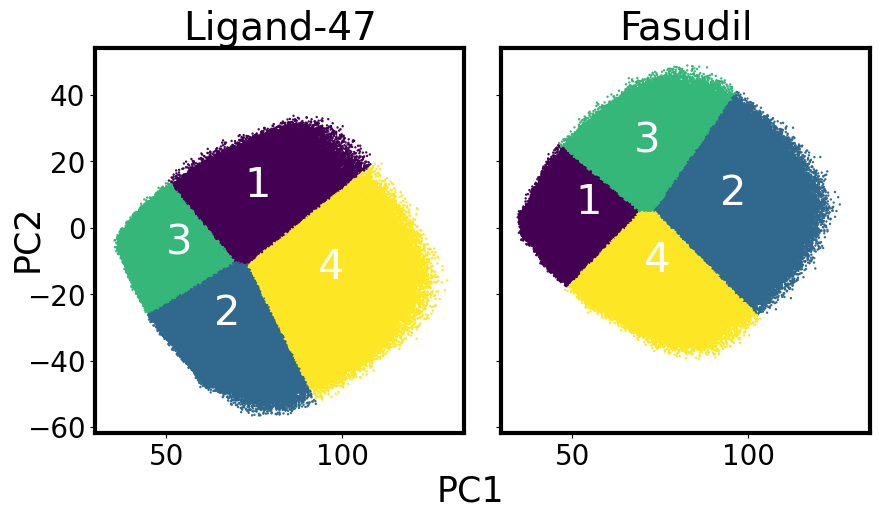

In [252]:
fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(10, 5))

xlabel = 'PC1'
ylabel = 'PC2'

ax[0].scatter(*pca_lig_47_[:,:2].T, c = dtraj_lig_47, s=.5)
for j,i in enumerate(clustercenters_lig_47):
    ax[0].annotate(f"{j+1}", [i[k] for k in range(2)], color="white", size="30")
    
ax[1].scatter(*pca_fasudil_[:,:2].T, c = dtraj_fasudil, s=.5)
for j,i in enumerate(clustercenters_fasudil):
    ax[1].annotate(f"{j+1}", [i[k] for k in range(2)], color="white", size="30")
ax[0].tick_params(axis='both', labelsize=20)    
ax[0].set_title('Ligand-47', size = 28)
ax[1].tick_params(axis='both', labelsize=20)
ax[1].set_title('Fasudil', size = 28)
plt.subplots_adjust(wspace=0.1)   
fig.supylabel(ylabel,x = .04,fontsize = 25)
fig.supxlabel(xlabel,y = -0.04,fontsize = 25)
plt.savefig('cluster_FES_PCA.pdf', bbox_inches="tight")

In [282]:
order_lig_47 = [0, 2, 1, 3]
clustercenters_lig_47_re = list( np.array(clustercenters_lig_47, dtype=object)[order_lig_47] )

order_fasudil = [3, 0, 2, 1]
clustercenters_fasudil_re = list( np.array(clustercenters_fasudil, dtype=object)[order_fasudil] )

#clustercenters_fasudil 1 3 2 0

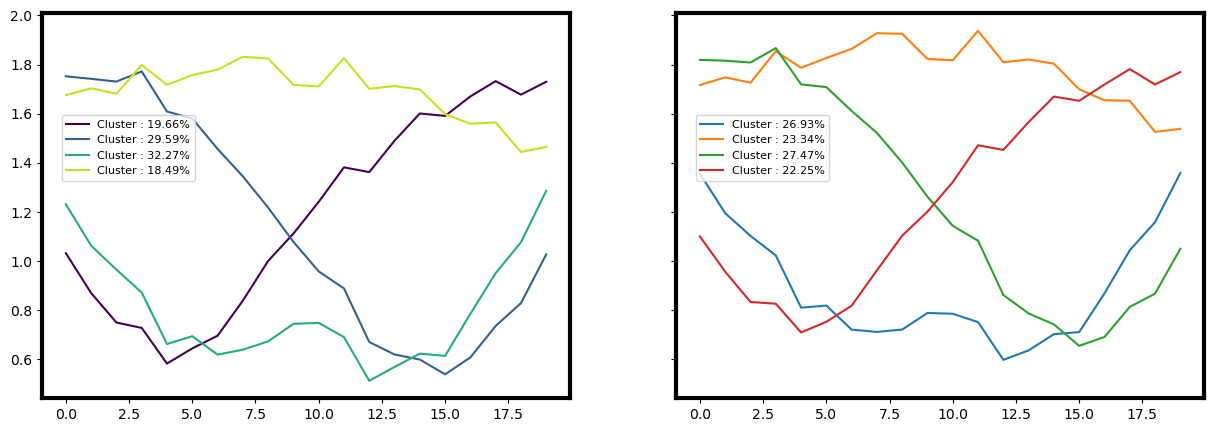

In [175]:
#xlabel = 'PC1'
ylabel = 'Number of Frames'

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15, 5))

count=0
for i in frames_cl_lig_47:
    ax[0].plot(dmat_lig_47[i].mean(0), color=plt.cm.viridis(round(310/4)*count), label = f"Cluster : {100*len(i)/len(dmat_lig_47):.2f}%")
    count+=1
    #print(count)
    ax[0].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    #plt.yticks(fontsize = 14)
    #plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    #plt.xlabel('Residue', fontsize = 20)
    #plt.ylabel('Average Distance\nfor Each Cluster', fontsize = 20)

for i in frames_cl_fasudil:
    ax[1].plot(dmat_fasudil[i].mean(0), label = f"Cluster : {100*len(i)/len(dmat_fasudil):.2f}%")
    ax[1].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    #plt.yticks(fontsize = 14)
    #plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    #plt.xlabel('Residue', fontsize = 20)
    #plt.ylabel('Average Distance\nfor Each Cluster', fontsize = 20)
    
#plt.subplots_adjust(wspace=0.1)

In [ ]:
state_mapping = {0:3, 1:2, 2:0, 3:1}
mapper = lambda x:state_mapping[x]
new_dtraj = list(map(mapper, dtraj))

In [ ]:
order_lig_47 = [0, 1, 2, 3]
frames_cl_lig_47_re = list( np.array(frames_cl_lig_47, dtype=object)[order_lig_47] )

order_fasudil = [3, 2, 0, 1]
frames_cl_fasudil_re = list( np.array(frames_cl_fasudil, dtype=object)[order_fasudil] )

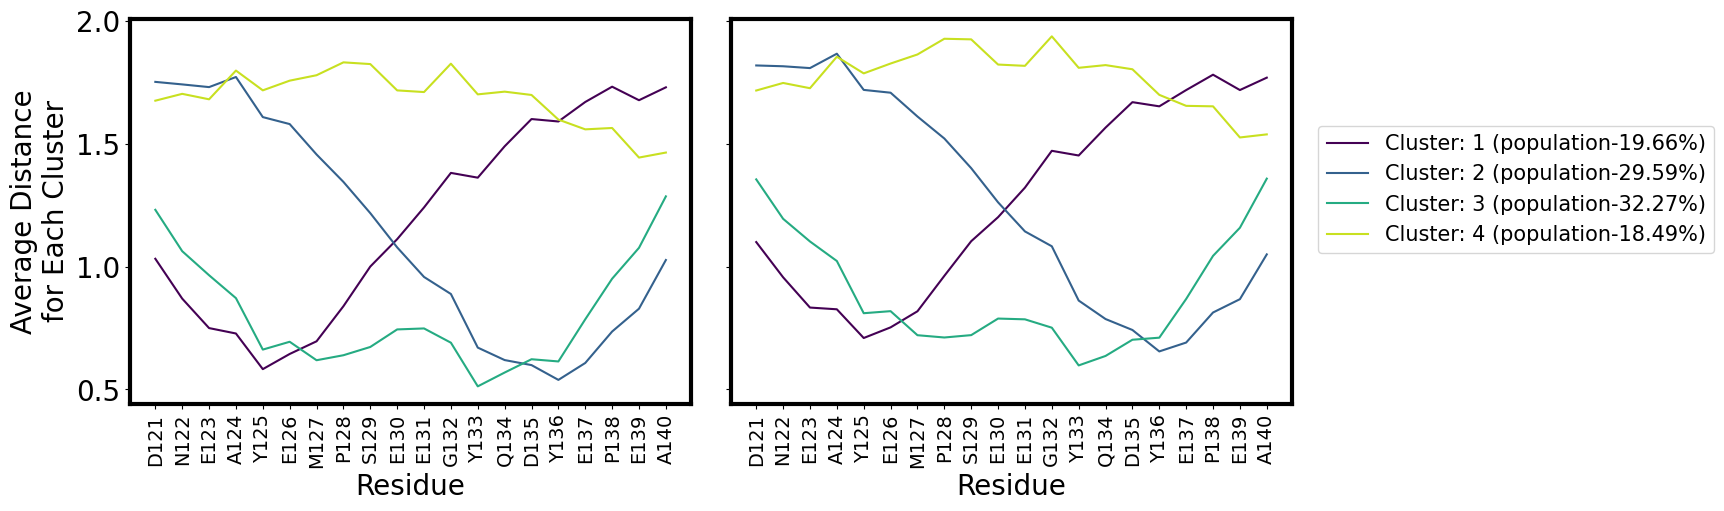

In [52]:
#xlabel = 'PC1'
ylabel = 'Number of Frames'

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(15, 5))

count=0
for i in frames_cl_lig_47_re:
    ax[0].plot(dmat_lig_47[i].mean(0), color=plt.cm.viridis(round(310/4)*count), label = f"Cluster: {count+1} (population-{100*len(i)/len(dmat_lig_47):.2f}%)")
    count+=1
    ax[0].legend(ncol = 1, prop={'size': 15}, bbox_to_anchor=(2.84, 0.75, 0., 0.))
    ax[0].tick_params(axis='both', labelsize=20)
    ax[0].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    ax[0].set_xlabel('Residue', fontsize = 20)
    ax[0].set_ylabel('Average Distance\nfor Each Cluster', fontsize = 20)
count=0
for i in frames_cl_fasudil_re:
    ax[1].plot(dmat_fasudil[i].mean(0), color=plt.cm.viridis(round(310/4)*count), label = f"Cluster : {100*len(i)/len(dmat_fasudil):.2f}%")
    count+=1
    #ax[1].legend(ncol = 1, prop={'size': 8}, bbox_to_anchor=(0.3, 0.75, 0., 0.))
    #plt.yticks(fontsize = 14)
    ax[1].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],('D121','N122','E123','A124','Y125','E126','M127','P128','S129','E130','E131','G132','Y133','Q134','D135','Y136','E137','P138','E139','A140'), rotation=90, fontsize = 14)
    ax[1].set_xlabel('Residue', fontsize = 20)
    #plt.ylabel('Average Distance\nfor Each Cluster', fontsize = 20)
    
plt.subplots_adjust(wspace=0.07)

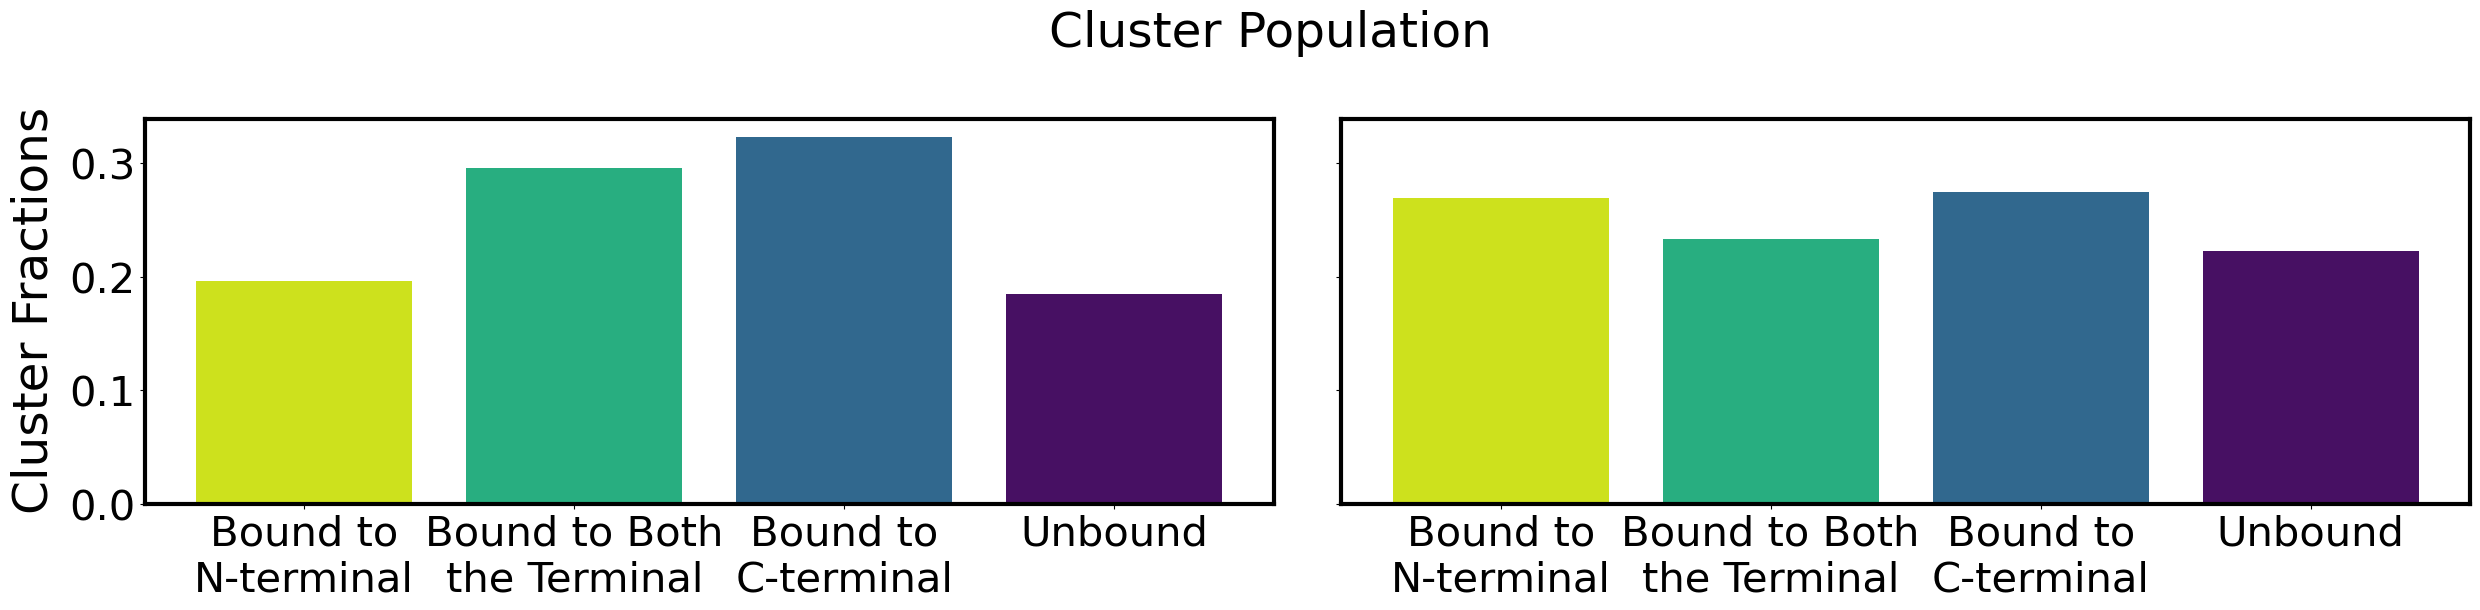

In [13]:
#xlabel = 'PC1'
ylabel = 'Cluster Fractions'

fig,ax = plt.subplots(1,2, sharex=True, sharey=True, figsize=(30, 5))

cluster_size_lig_47 = []
for i in frames_cl_lig_47:
    cluster_size_lig_47.append(i.size)
    
cluster_size_lig_47_ = np.array(cluster_size_lig_47)

cluster_fraction_lig47=[]
for i in range (4):
    cluster_fraction_lig47.append(cluster_size_lig_47_[i]/cluster_size_lig_47_.sum())
    
langs = ['Bound to\nN-terminal', 'Bound to Both\nthe Terminal', 'Bound to\nC-terminal', 'Unbound']#, 'C_5']#, 'C_6', 'C_7', 'C_8']
ax[0].bar(langs, cluster_fraction_lig47, color = clist)


cluster_size_fasudil = []
for j in frames_cl_fasudil:
    cluster_size_fasudil.append(j.size)

cluster_size_fasudil_ = np.array(cluster_size_fasudil)

cluster_fraction_fasudil=[]
for i in range (4):
    cluster_fraction_fasudil.append(cluster_size_fasudil_[i]/cluster_size_fasudil_.sum())
    
#langs = ['Bound to\nC-terminal', 'Bound to\nN-terminal', 'Bound to Both\nthe Terminals', 'Unbound']#, 'C_5']#, 'C_6', 'C_7', 'C_8']
ax[1].bar(langs, cluster_fraction_fasudil, color = clist)

ax[0].tick_params(axis='both', labelsize=30)    
#ax[0].set_title('Ligand-47', size = 28, pad =2)
#ax[0].set_yticks(range(0,500000,100000), ('0', '$10x10^4$', '$20x10^4$', '$30x10^4$', '$40x10^4$'))
ax[1].tick_params(axis='both', labelsize=30)
#ax[1].set_title('Fasudil', size = 28)
plt.subplots_adjust(wspace=0.06)   
fig.supylabel(ylabel,x = .08,fontsize = 35)
#fig.supxlabel(xlabel,y = -0.04,fontsize = 25)
fig.suptitle("Cluster Population",y = 1.1,size=35)
plt.savefig('cluster_population_PCA.pdf', bbox_inches="tight")

In [18]:
msm_lig_47 = pyemma.msm.estimate_markov_model(dtraj_lig_47_new, lag = 10, reversible=False)
msm_fasudil = pyemma.msm.estimate_markov_model(dtraj_fasudil_new, lag = 10, reversible=False)

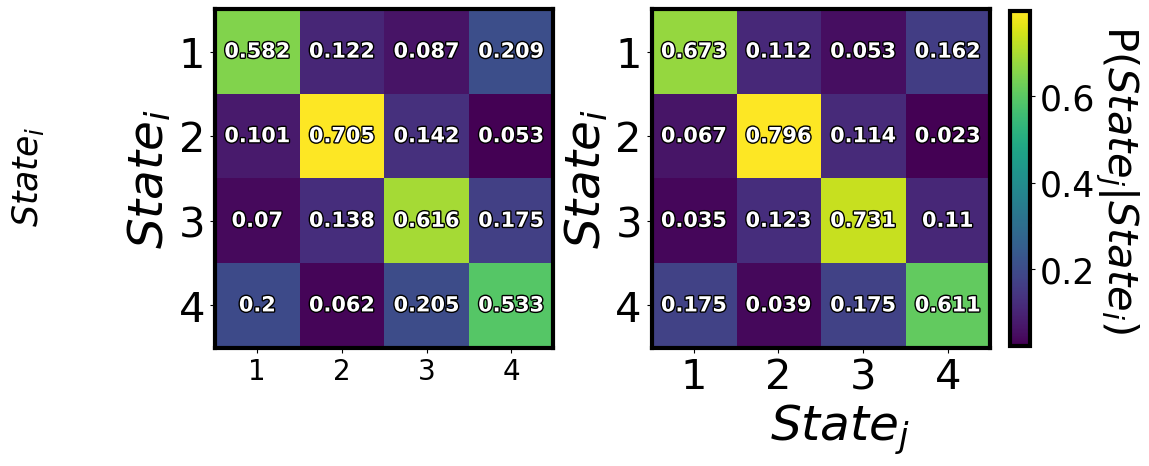

In [29]:
#transition matrix errors
xlabel = r"$State_{j}$"
ylabel = r"$State_{i}$"

fig,ax = plt.subplots(1,2, sharex=True, sharey=False, figsize=(10, 5))


a = plot_mat_error(msm_lig_47.transition_matrix,1,"%",15,"white","viridis",np.arange(4))

plot_mat_error(msm_fasudil.transition_matrix,0,"%",15,"white","viridis",np.arange(4))

#a = plot_mat_error(msm_lig_47.transition_matrix,0,"Transition Matrix\nligand-47","%",10,"white","viridis",np.arange(4))

#plot_mat_error(msm_fasudil.transition_matrix,1,"Transition Matrix\nFasudil","%",10,"white","viridis",np.arange(4))

ax[1].set_yticks([0,1,2,3],('1','2','3', '4'), fontsize = 30)
ax[1].set_xticks([0,1,2,3],('1','2','3', '4'), fontsize = 30)
ax[0].set_yticks([0,1,2,3],('1','2','3', '4'), fontsize = 30)
cbar_ax = fig.add_axes([.92, 0.16, 0.02, 0.67])#[left, bottom, width, height]
cbar = fig.colorbar(a, cax = cbar_ax)
cbar.ax.tick_params(labelsize=25)
cbar.set_label(r"P($State_{j}$|$State_{i}$)", labelpad=32, fontsize=30, rotation= 270)

#fig.suptitle("Transition Matrix \n($\\tau$=1.8ns)",y = 1.0,x = .75, size=25)
fig.supylabel(ylabel,x = -0.08,fontsize = 25)
fig.supxlabel(xlabel,y = -0.06,x = .75, fontsize = 35)
plt.subplots_adjust(wspace=0.29)

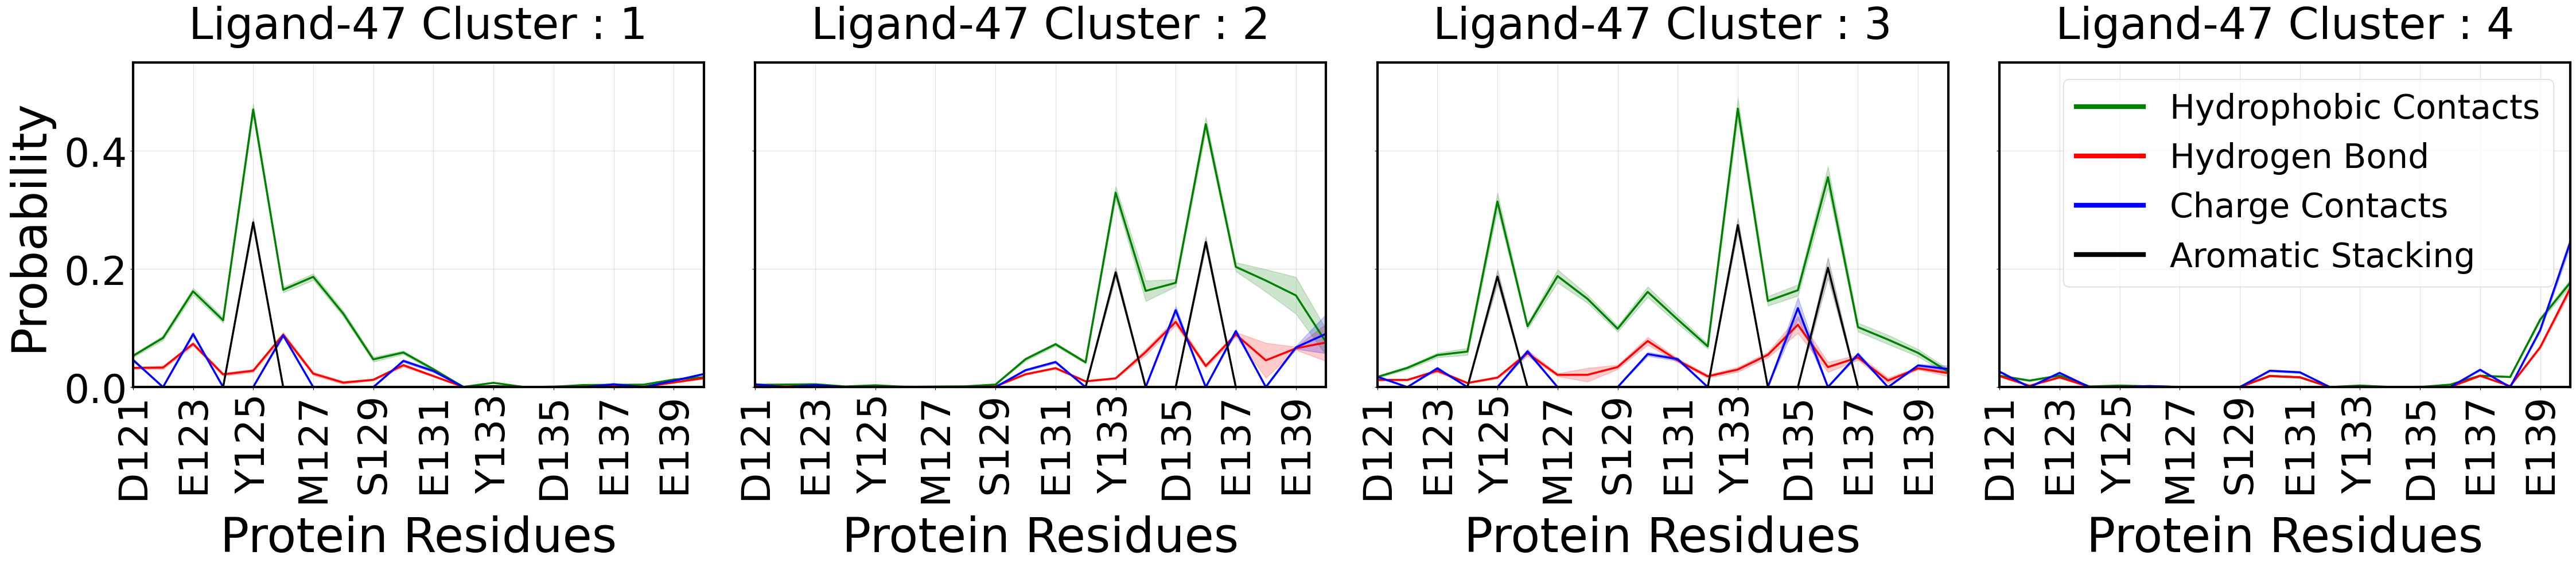

In [124]:
Hbond= np.load("/data/asn/tica/lig_47/combined/intermol_Hbond_pca_combined_lig.npy" )
charge_= np.load("/data/asn/tica/lig_47/combined/intermol_charge_pca_combined_lig.npy")
aro_ = np.load("/data/asn/tica/lig_47/combined/intermol_aro_pca_combined_lig.npy")
hydro = np.load("/data/asn/tica/lig_47/combined/intermol_hydro_pca_combined_lig.npy")

fig, ax = plt.subplots(1, 4, figsize=(45, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro[i].T[0], hydro[i].T[1], linewidth=2.5, label='Hydrophobic Contacts', color='green')
    ax[p].fill_between(hydro[i].T[0], hydro[i].T[1]-hydro[i].T[2],
                          hydro[i].T[1]+hydro[i].T[2], alpha=0.2,color='green')
    
    ax[p].plot(Hbond[i].T[0], Hbond[i].T[1], linewidth=2.5,label='Hydrogen Bond', color='red')
    ax[p].fill_between(Hbond[i].T[0], Hbond[i].T[1]-Hbond[i].T[2],
                          Hbond[i].T[1]+Hbond[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge_[i].T[0], charge_[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge_[i].T[0], charge_[i].T[1]-charge_[i].T[2],
                          charge_[i].T[1]+charge_[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro_[i].T[0], aro_[i].T[1], linewidth=2.5, color='black', label='Aromatic Stacking')
    ax[p].fill_between(aro_[i].T[0], aro_[i].T[1]-aro_[i].T[2],
                         aro_[i].T[1]+aro_[i].T[2], alpha=0.2,color='black')
    
    ax[p].set_ylim(0,0.55)
    ax[p].set_xlim(121,140)
    ax[p].set_xticks(range(int(min(Hbond[i][:,0])),int(max(Hbond[i][:,0])+1),2))
    ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize=50)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90)
    
    
    if i == 3:
        leg=ax[p].legend(loc=1,prop={'size': 42})
        for legobj in leg.legendHandles:
            legobj.set_linewidth(6.0)
    

    a='Ligand-47 Cluster : '+str(i+1)
    ax[p].set_title(a,size=55, pad=30)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=60, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=60, labelpad=15)
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.09)

In [160]:
Hbond= np.load("intermol_Hbond_pca_combined_lig.npy" )
charge_= np.load("intermol_charge_pca_combined_lig.npy")
aro_ = np.load("intermol_aro_pca_combined_lig.npy")
hydro = np.load("intermol_hydro_pca_combined_lig.npy")

order = [0,2,1,3]
aro__=aro_[order]
Hbond_=Hbond[order]
charge__=charge_[order]
hydro_=hydro[order]

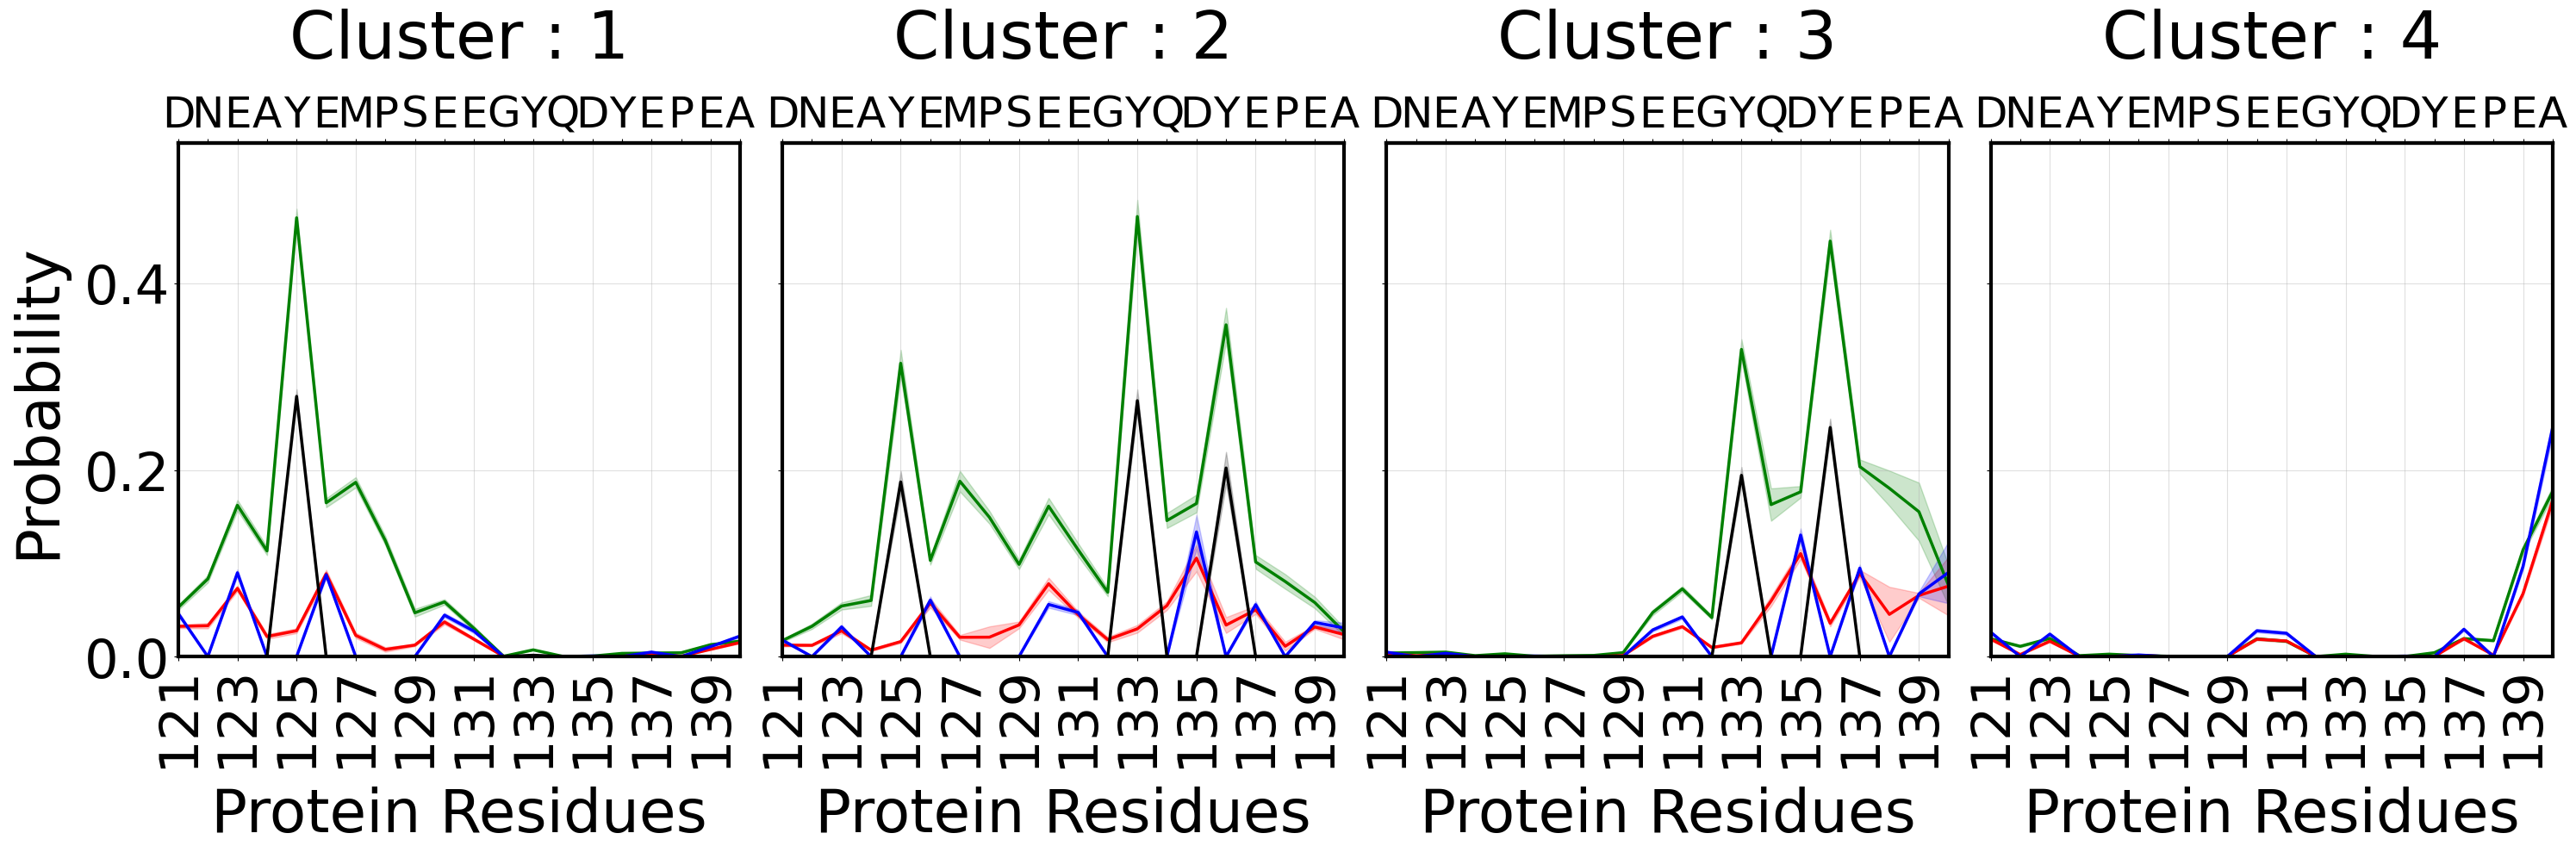

In [161]:
fig, ax = plt.subplots(1, 4, figsize=(30, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('121','123','125','127','129','131','133','135','137','139')

res__ = ('D','N','E','A','Y','E','M','P','S','E','E','G','Y','Q','D','Y','E','P','E','A')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro_[i].T[0], hydro_[i].T[1], linewidth=2.5, label='hydro_phobic Contacts', color='green')
    ax[p].fill_between(hydro_[i].T[0], hydro_[i].T[1]-hydro_[i].T[2],
                          hydro_[i].T[1]+hydro_[i].T[2], alpha=0.2,color='green')
    
    ax[p].plot(Hbond_[i].T[0], Hbond_[i].T[1], linewidth=2.5,label='hydro_gen Bond', color='red')
    ax[p].fill_between(Hbond_[i].T[0], Hbond_[i].T[1]-Hbond_[i].T[2],
                          Hbond_[i].T[1]+Hbond_[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge__[i].T[0], charge__[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge__[i].T[0], charge__[i].T[1]-charge__[i].T[2],
                          charge__[i].T[1]+charge__[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro__[i].T[0], aro__[i].T[1], linewidth=2.5, color='black', label='Aromatic Stacking')
    ax[p].fill_between(aro__[i].T[0], aro__[i].T[1]-aro__[i].T[2],
                         aro__[i].T[1]+aro__[i].T[2], alpha=0.2,color='black')
    
    ax[p].set_ylim(0,0.55)
    ax[p].set_xlim(121,140)
    ax[p].set_xticks(range(int(min(Hbond_[i][:,0])),int(max(Hbond_[i][:,0])+1),2))
    #ax[p].set_xticklabels([])
    #ax[p].grid(True)
    #ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize= 45)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90) 
    
    
    #if i == 3:
        #leg=ax[p].legend(loc=1,prop={'size': 42})
        #for legobj in leg.legendHandles:
            #legobj.set_linewidth(6.0)
    

    a='Cluster : '+str(i+1)
    ax[p].set_title(a,size=55, pad=30)
#     ax[0].set_title('Cluster-1 (19.66%)',size=50,pad=30)
#     ax[1].set_title('Cluster-2 (32.27%)',size=50,pad=30)
#     ax[2].set_title('Cluster-3 (29.59%)',size=50, pad=30)
#     ax[3].set_title('Cluster-4 (18.49%)',size=50, pad=30)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=50, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=50, labelpad=15)
    
    secax1 = ax[p].secondary_xaxis('top')
    #secax2 = ax[1].secondary_xaxis('top')
# secax1.grid(which='both', alpha=0.5)
# secax2.grid(which='both', alpha=0.5)
# secax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    secax1.set_xticks(range(121, 121+20))
    #secax2.set_xticks(range(391, 391+24))
    secax1.set_xticklabels(res__)
    #secax2.set_xticklabels(sequence_ol)
    secax1.tick_params(labelsize=36)
    #secax2.tick_params(labelsize=16)
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.075)
plt.savefig('Lig47_contact_PCA.pdf', bbox_inches="tight")

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

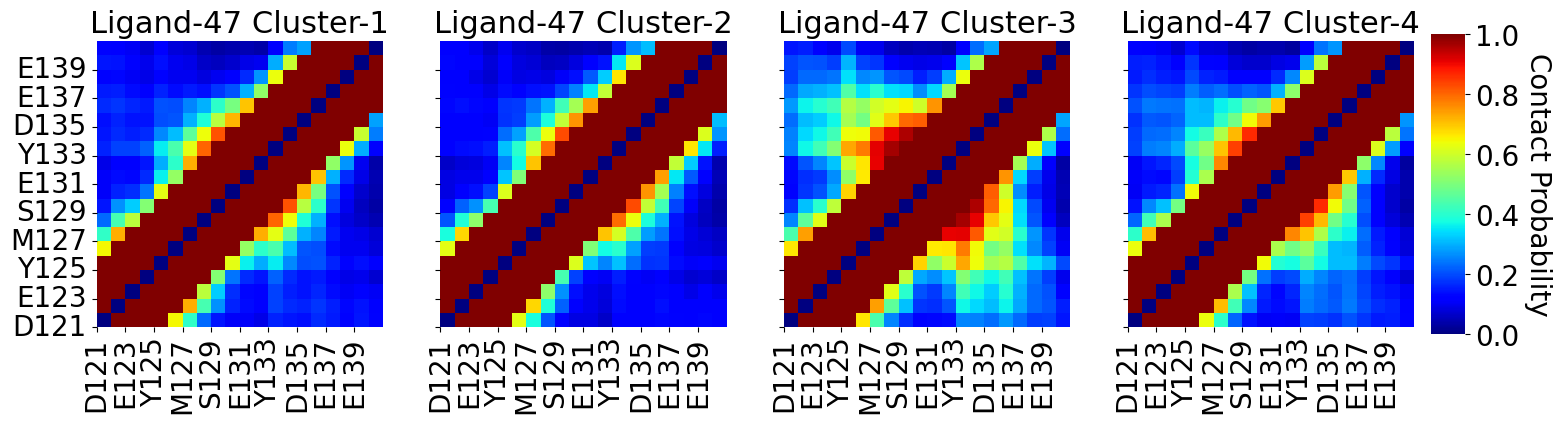

In [169]:
C = np.load("pep_contact_pca_combined_lig.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "jet",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Ligand-47 Cluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_pep_contact.png', bbox_inches="tight")

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

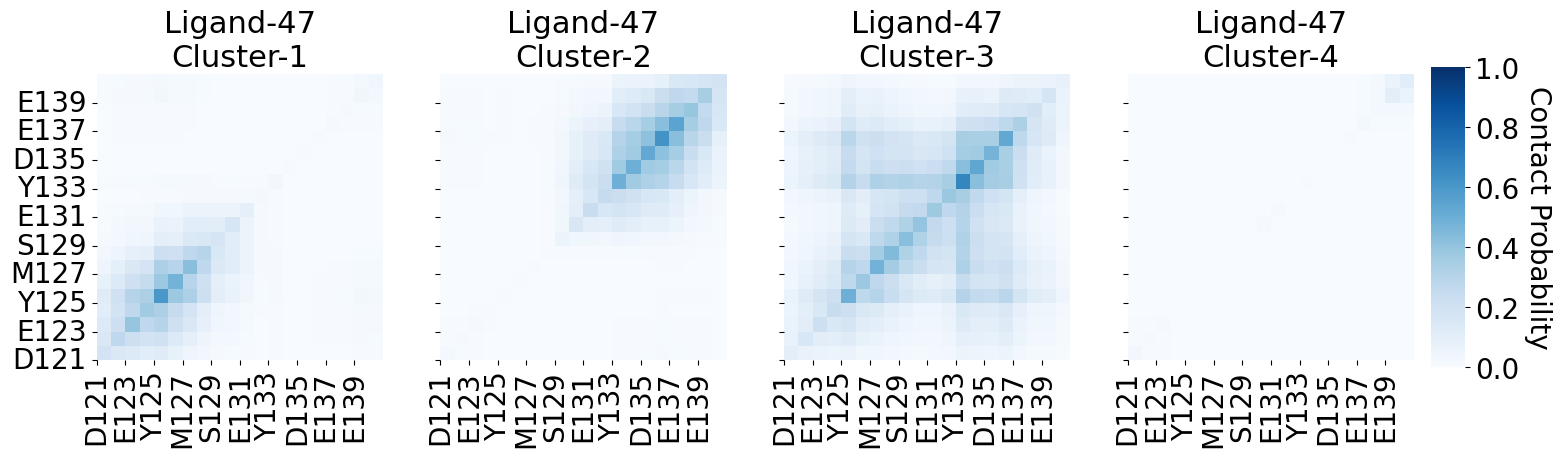

In [171]:
C_ = np.load("dual_contact_pca_combined_lig.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C_[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "Blues",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Ligand-47\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_dual_contact.png', bbox_inches="tight")

In [157]:
Hbond= np.load("/home/apara/asn/tica/fasudil/combined/intermol_Hbond_pca_combined_fas.npy" )
charge_= np.load("/home/apara/asn/tica/fasudil/combined/intermol_charge_pca_combined_fas.npy")
aro_ = np.load("/home/apara/asn/tica/fasudil/combined/intermol_aro_pca_combined_fas.npy")
hydro = np.load("/home/apara/asn/tica/fasudil/combined/intermol_hydro_pca_combined_fas.npy")

order = [3,0,2,1]
aro__=aro_[order]
Hbond_=Hbond[order]
charge__=charge_[order]
hydro_=hydro[order]

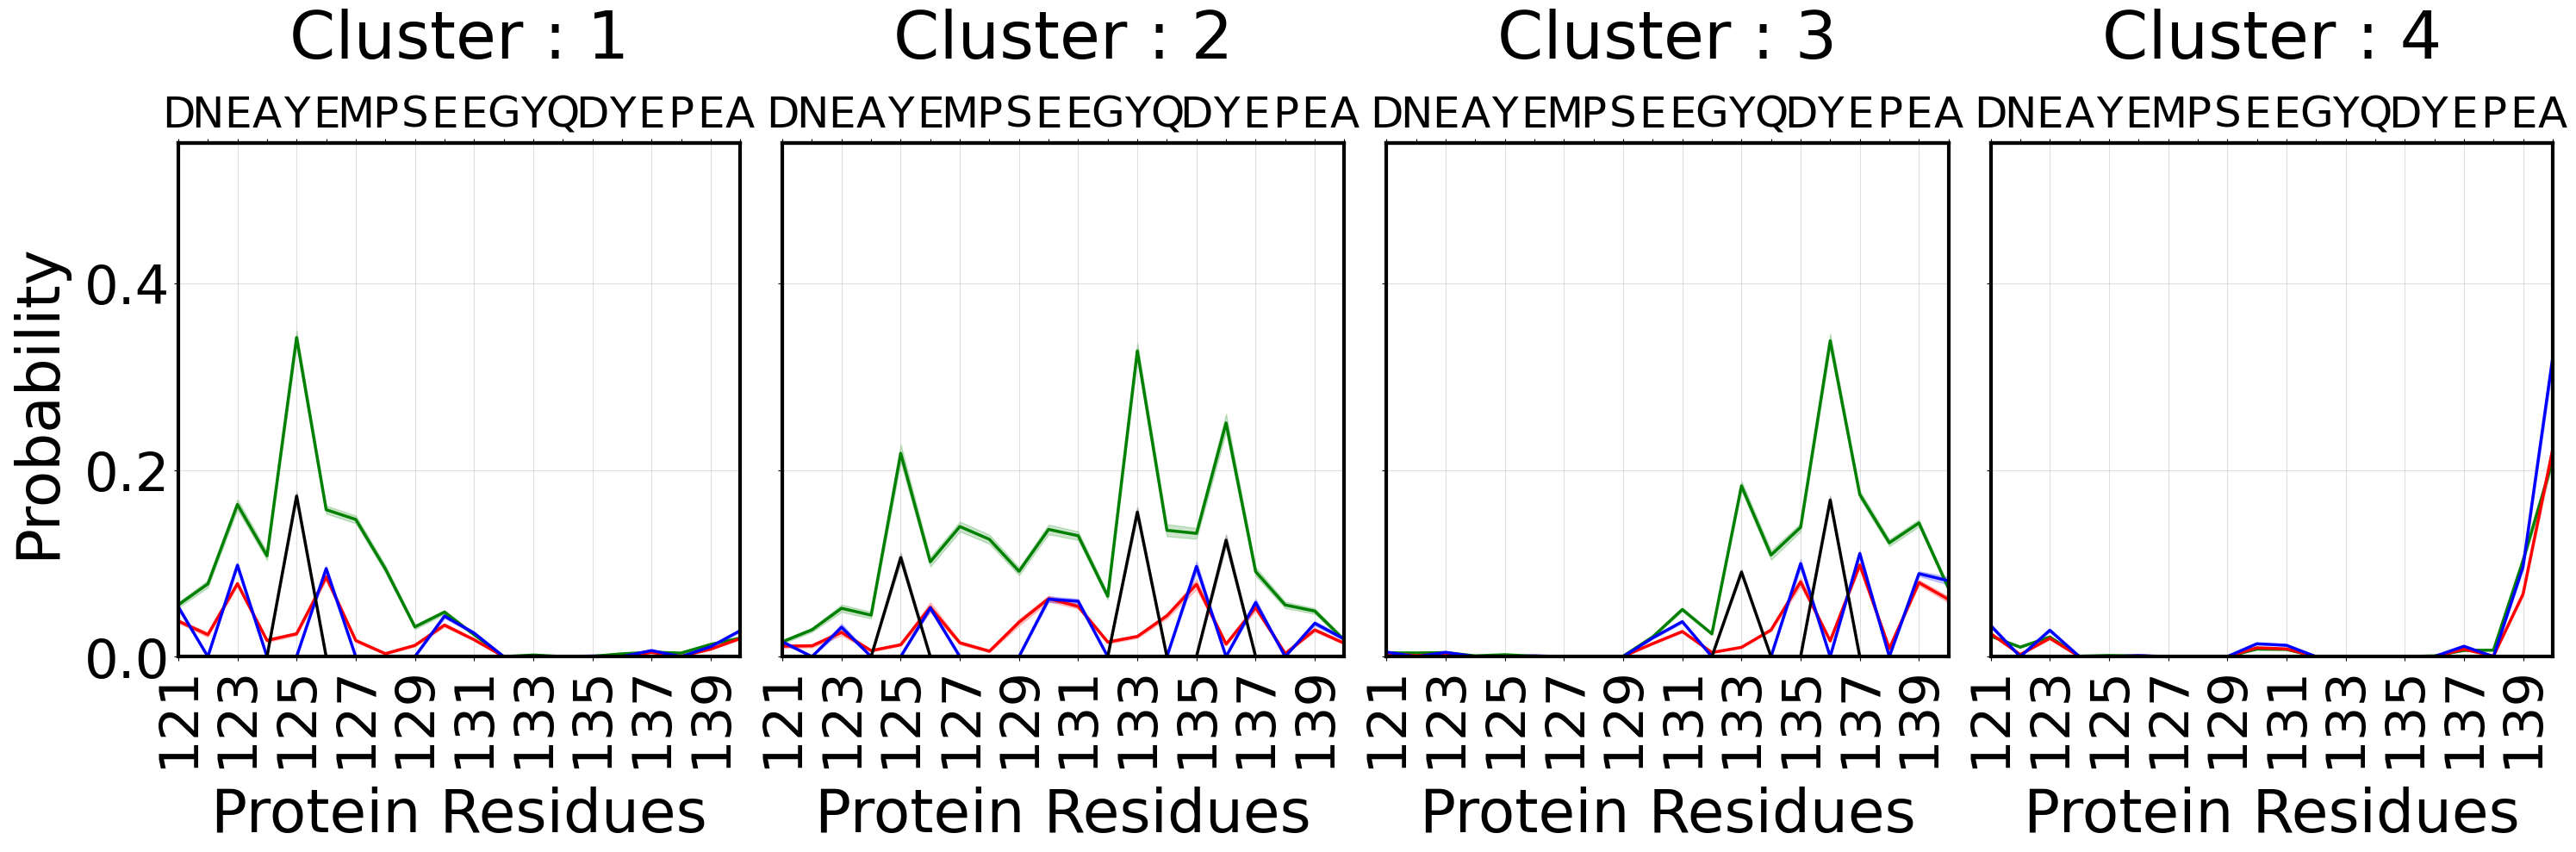

In [158]:
fig, ax = plt.subplots(1, 4, figsize=(30, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('121','123','125','127','129','131','133','135','137','139')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro_[i].T[0], hydro_[i].T[1], linewidth=2.5, label='hydro_phobic Contacts', color='green')
    ax[p].fill_between(hydro_[i].T[0], hydro_[i].T[1]-hydro_[i].T[2],
                          hydro_[i].T[1]+hydro_[i].T[2], alpha=0.2,color='green')
    
    ax[p].plot(Hbond_[i].T[0], Hbond_[i].T[1], linewidth=2.5,label='hydro_gen Bond', color='red')
    ax[p].fill_between(Hbond_[i].T[0], Hbond_[i].T[1]-Hbond_[i].T[2],
                          Hbond_[i].T[1]+Hbond_[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge__[i].T[0], charge__[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge__[i].T[0], charge__[i].T[1]-charge__[i].T[2],
                          charge__[i].T[1]+charge__[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro__[i].T[0], aro__[i].T[1], linewidth=2.5, color='black', label='Aromatic Stacking')
    ax[p].fill_between(aro__[i].T[0], aro__[i].T[1]-aro__[i].T[2],
                         aro__[i].T[1]+aro__[i].T[2], alpha=0.2,color='black')
    
   
    
    ax[p].set_ylim(0,0.55)
    ax[p].set_xlim(121,140)
    ax[p].set_xticks(range(int(min(Hbond_[i][:,0])),int(max(Hbond_[i][:,0])+1),2))
    #ax[p].set_xticklabels([])
    #ax[p].grid(True)
    ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize=45)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90) 
    
    
    #if i == 3:
        #leg=ax[p].legend(loc=1,prop={'size': 42})
        #for legobj in leg.legendHandles:
            #legobj.set_linewidth(6.0)
    

    a='Cluster : '+str(i+1)
    ax[p].set_title(a,size=55, pad=30)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=50, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=50, labelpad=15)
    
    secax1 = ax[p].secondary_xaxis('top')
    #secax2 = ax[1].secondary_xaxis('top')
# secax1.grid(which='both', alpha=0.5)
# secax2.grid(which='both', alpha=0.5)
# secax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    secax1.set_xticks(range(121, 121+20))
    #secax2.set_xticks(range(391, 391+24))
    secax1.set_xticklabels(res__)
    #secax2.set_xticklabels(sequence_ol)
    secax1.tick_params(labelsize=36)
    #secax2.tick_params(labelsize=16)
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.075)
plt.savefig('fasudil_contact_PCA.pdf', bbox_inches="tight")

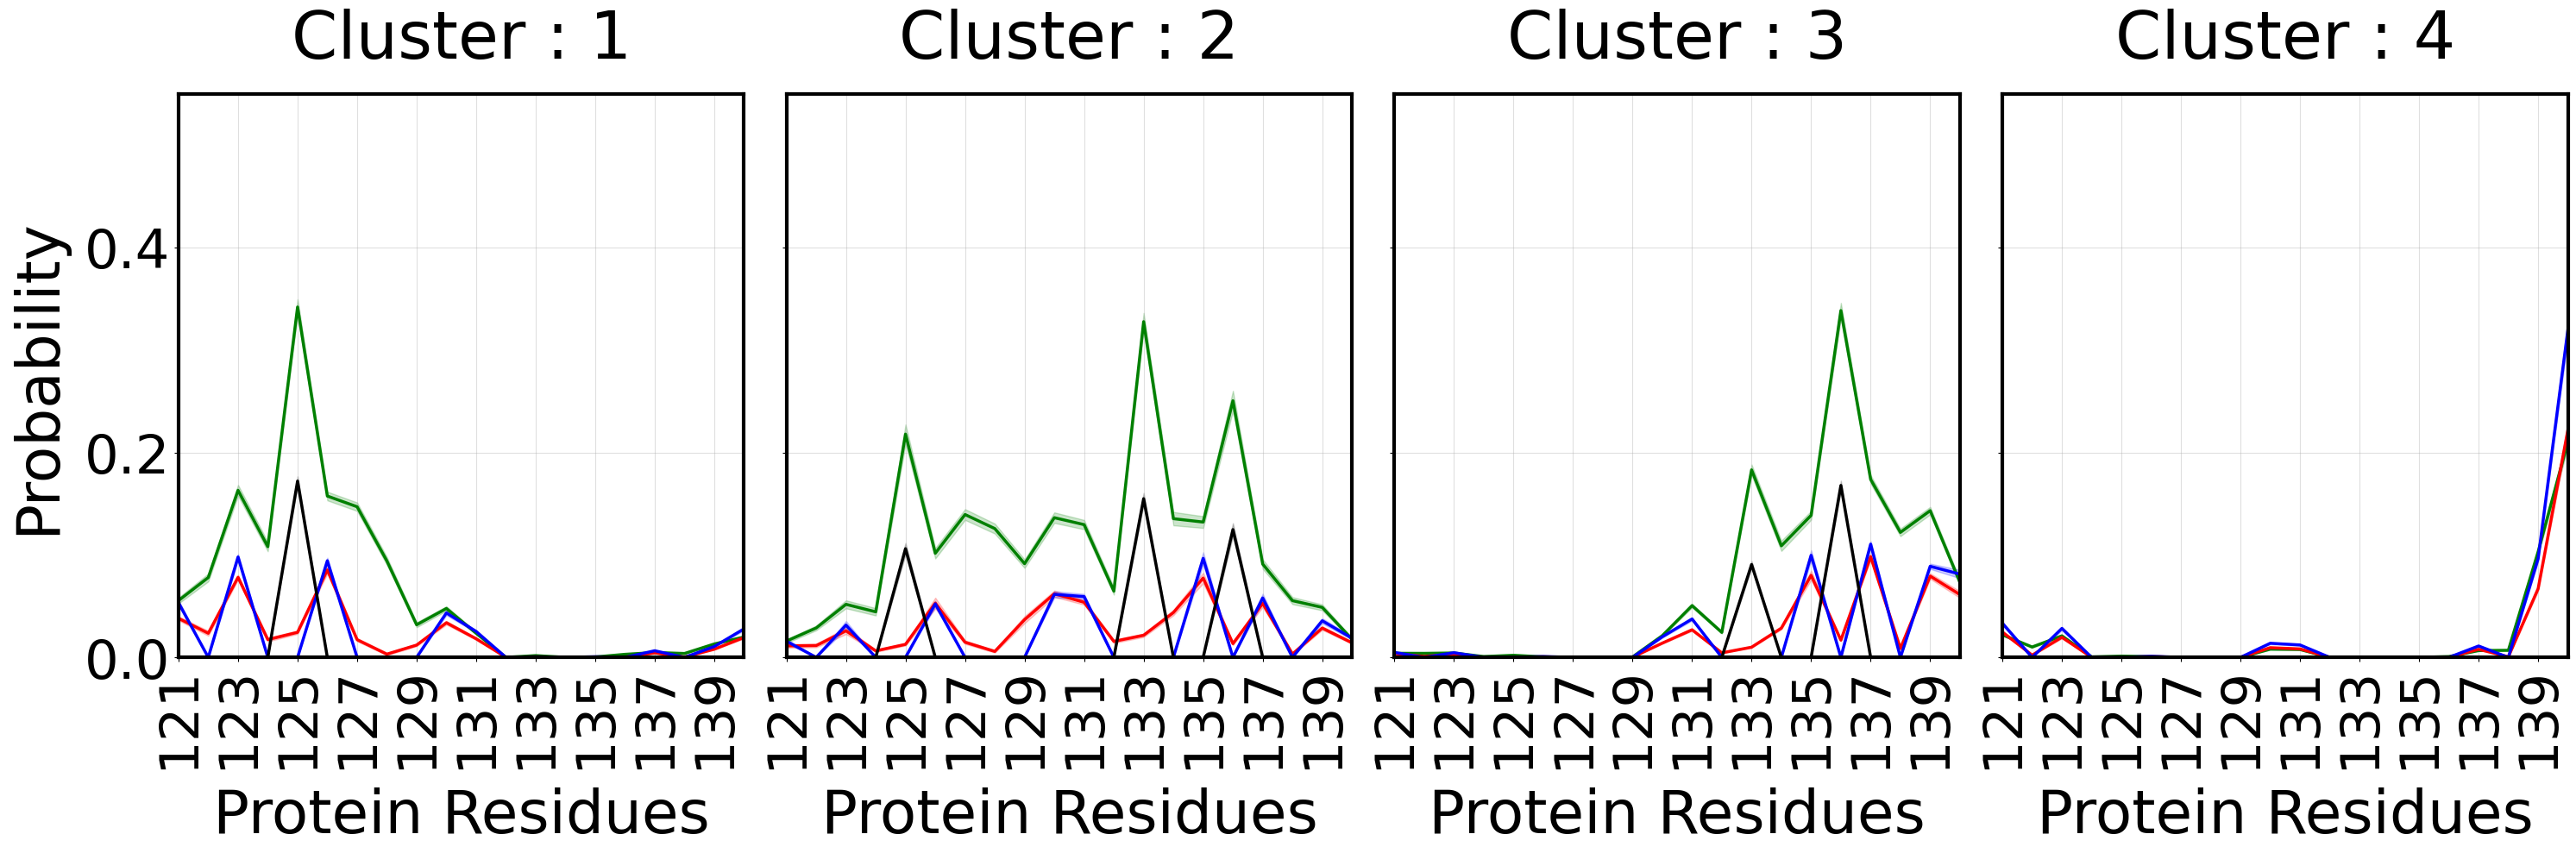

In [159]:
fig, ax = plt.subplots(1, 4, figsize=(30, 10), sharex=True, sharey=True)
#res = np.array([str(trj[0].topology.residue(i)) for i in range(20)])
res_ = ('121','123','125','127','129','131','133','135','137','139')

for i in range(4):
    p = np.unravel_index(i,(4))
    
    ax[p].plot(hydro_[i].T[0], hydro_[i].T[1], linewidth=2.5, label='hydro_phobic Contacts', color='green')
    ax[p].fill_between(hydro_[i].T[0], hydro_[i].T[1]-hydro_[i].T[2],
                          hydro_[i].T[1]+hydro_[i].T[2], alpha=0.2,color='green')
    
    ax[p].plot(Hbond_[i].T[0], Hbond_[i].T[1], linewidth=2.5,label='hydro_gen Bond', color='red')
    ax[p].fill_between(Hbond_[i].T[0], Hbond_[i].T[1]-Hbond_[i].T[2],
                          Hbond_[i].T[1]+Hbond_[i].T[2], alpha=0.2,color='r')
    
    ax[p].plot(charge__[i].T[0], charge__[i].T[1], linewidth=2.5,label='Charge Contacts',c='blue')
    ax[p].fill_between(charge__[i].T[0], charge__[i].T[1]-charge__[i].T[2],
                          charge__[i].T[1]+charge__[i].T[2], alpha=0.2,color='blue')
    
    ax[p].plot(aro__[i].T[0], aro__[i].T[1], linewidth=2.5, color='black', label='Aromatic Stacking')
    ax[p].fill_between(aro__[i].T[0], aro__[i].T[1]-aro__[i].T[2],
                         aro__[i].T[1]+aro__[i].T[2], alpha=0.2,color='black')
    
   
    
    ax[p].set_ylim(0,0.55)
    ax[p].set_xlim(121,140)
    ax[p].set_xticks(range(int(min(Hbond_[i][:,0])),int(max(Hbond_[i][:,0])+1),2))
    #ax[p].set_xticklabels([])
    #ax[p].grid(True)
    ax[p].set_xticklabels(res_)
    ax[p].tick_params(labelsize=45)
    ax[p].grid(alpha=0.4)
    plt.setp(ax[p].get_xticklabels(), rotation=90) 
    
    
    #if i == 3:
        #leg=ax[p].legend(loc=1,prop={'size': 42})
        #for legobj in leg.legendHandles:
            #legobj.set_linewidth(6.0)
    

    a='Cluster : '+str(i+1)
    ax[p].set_title(a,size=55, pad=30)
    
    #text_=r'$K_{D}$'+' : '+str(round(K[2][i],2))+r'$\pm$'+str(round(K[3][i],2))
    #ax[p].text(120.3, 0.63, text_, fontsize = 26)
    
    ax[0].set_ylabel("Probability", size=50, labelpad=15)
    ax[p].set_xlabel('Protein Residues', size=50, labelpad=15)
    
    #secax1 = ax[p].secondary_xaxis('top')
    #secax2 = ax[1].secondary_xaxis('top')
# secax1.grid(which='both', alpha=0.5)
# secax2.grid(which='both', alpha=0.5)
# secax1.xaxis.set_minor_locator(AutoMinorLocator(2))
    #secax1.set_xticks(range(121, 121+20))
    #secax2.set_xticks(range(391, 391+24))
    #secax1.set_xticklabels(res__)
    #secax2.set_xticklabels(sequence_ol)
    #secax1.tick_params(labelsize=36)
    #secax2.tick_params(labelsize=16)
        
plt.tight_layout()
plt.subplots_adjust(wspace=0.075)
plt.savefig('fasudil_contact_PCA.pdf', bbox_inches="tight")

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

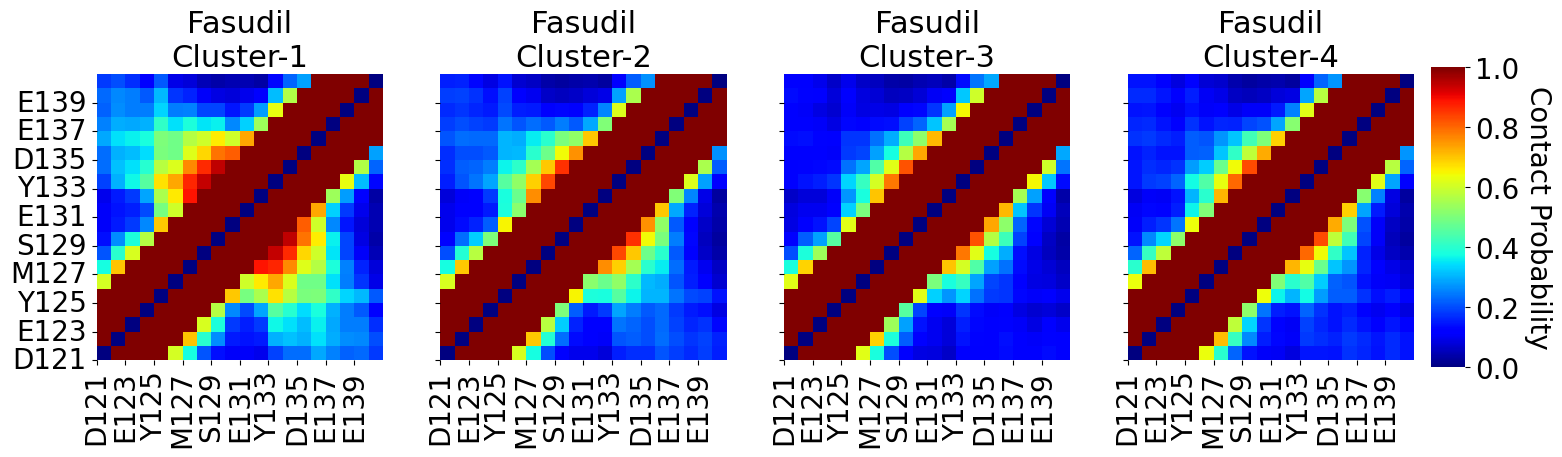

In [6]:
C = np.load("/data/asn/tica/fasudil/combined/pep_contact_pca_combined_fas.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "jet",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Fasudil\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_pep_contact.png', bbox_inches="tight")

Text(1618.4027777777778, 0.5, 'Contact Probability')

<Figure size 640x480 with 0 Axes>

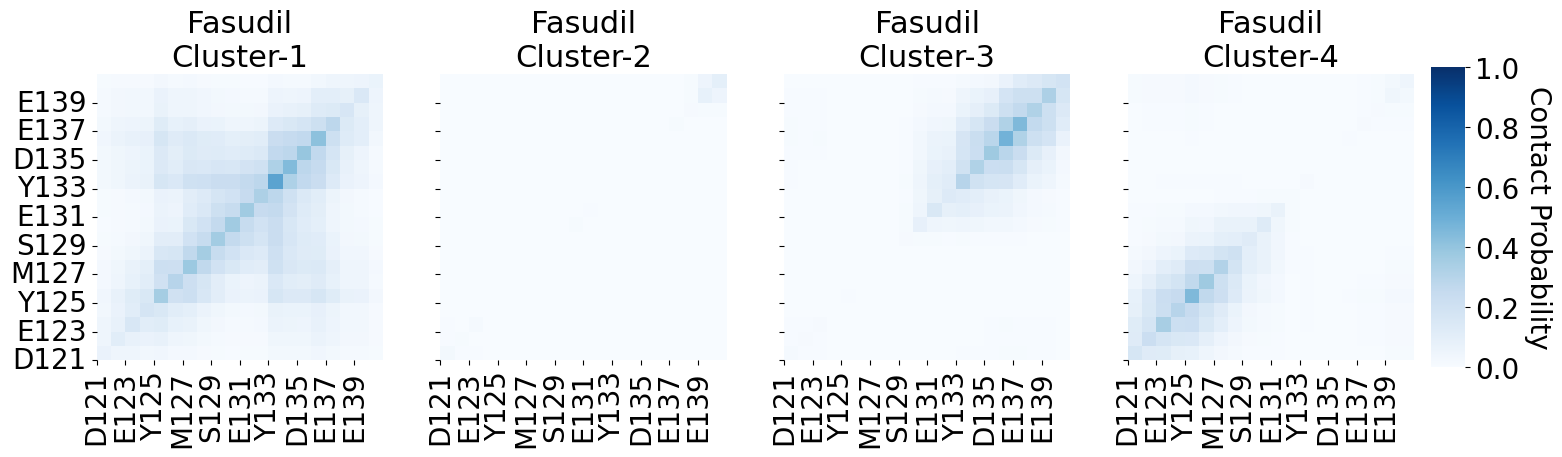

In [7]:
C_ = np.load("/data/asn/tica/fasudil/combined/dual_contact_pca_combined_fas.npy")
res_ = ('D121','E123','Y125','M127','S129','E131','Y133','D135','E137','E139')
#title = 'Mutual Information \n Charge-contacts - Intermolecular-distances'
#xlabel = 'Intermolecular-distances'
#ylabel = 'Charge-contacts'
plt.subplots_adjust(wspace=0.01, hspace=1)
ncol = 4
nrow = 1
fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(17, 4))
cbar_ax = fig.add_axes([.91, .12, .02, .75])
for i in range(4):
    #contact_map = np.loadtxt(f"./Analysis/contact_map.{i}.dat")
    contact_map = C_[i]
    p = np.unravel_index(i,(5))
    cb = i==1
    plot = sns.heatmap(contact_map, ax=ax[p], vmin = 0, vmax= 1, cmap = "Blues",  cbar=cb, cbar_ax=cbar_ax)
                  #xticklabels = res, yticklabels = charge_res)
    #cbar = ax.collections[0].colorbar
    #cbar.set_label(label = "MI",size = 15)
    #cbar.ax.tick_params(labelsize=15)
    ax[p].invert_yaxis()
    ax[p].tick_params(axis = 'x', rotation = 90)
    ax[p].set_title('Fasudil\nCluster-'+str(i+1),size=22)
    ax[p].set_aspect('equal', 'box')
    ax[p].set_xticks(range(0, 20,2), res_, rotation=90, size=20)
    ax[p].set_yticks(range(0, 20,2), res_, rotation=0, size=20)
    #ax[p].set_xlabel(xlabel, size = 15)
    #ax[p].set_ylabel(ylabel, size = 15)
cbar_ax.tick_params(labelsize=20)
cbar_ax.set_ylabel('Contact Probability', rotation=270, fontsize = 20, labelpad=24)
#plt.savefig('Lig47_dual_contact.png', bbox_inches="tight")